# Importing Libraries

In [3]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import random
import simpy

This cell imports necessary libraries for data handling, spatial analysis, network graph processing, simulation, and visualization:
- osmnx: For querying and analyzing OpenStreetMap data.
- networkx: For graph-based operations.
- geopandas: To handle geospatial data.
- matplotlib: For plotting graphs and maps.
- shapely: For geometric operations.
- simpy: For simulating the delivery environment.

# Loading Dublin 8 Boundary and Network

In [5]:
# Step 1: Get the Dublin 8 Boundary
area_name = "Dublin 8, Dublin, Ireland"
dublin8_gdf = ox.geocode_to_gdf(area_name)  # Geocode Dublin 8 boundary
dublin8_polygon = dublin8_gdf.loc[0, 'geometry']

# Step 2: Load the Street Network for Dublin 8
G = ox.graph_from_polygon(dublin8_polygon, network_type='bike')  # Get bike network
G = ox.add_edge_speeds(G)  # Assign bike speeds
G = ox.add_edge_travel_times(G)  # Add travel times

print("Dublin 8 boundary and street network loaded successfully!")


Dublin 8 boundary and street network loaded successfully!


This code retrieves the boundary of Dublin 8 using osmnx.geocode_to_gdf.
It extracts the bicycle street network using ox.graph_from_polygon.

The network is enhanced by adding:
- Edge speeds: Using ox.add_edge_speeds.
- Travel times: Using ox.add_edge_travel_times.

# Querying Pharmacies in Dublin 8

In [4]:
# Step 3: Query Pharmacies in Dublin 8
pharmacies_gdf = ox.features_from_polygon(dublin8_polygon, tags={"amenity": "pharmacy"})

# Filter only Point geometries (skip Polygons)
pharmacies_points = pharmacies_gdf[pharmacies_gdf.geometry.type == "Point"]

# Extract pharmacy coordinates
pharmacies_coords = [(point.y, point.x) for point in pharmacies_points["geometry"]]

print("\nExtracted Pharmacy Coordinates:")
print(pharmacies_coords)



Extracted Pharmacy Coordinates:
[(53.3378085, -6.2660283), (53.3395383, -6.3205083), (53.3323216, -6.2747431), (53.3429837, -6.2758169), (53.3359616, -6.298119), (53.332346, -6.273371), (53.3393398, -6.3208171), (53.3447899, -6.2971496), (53.3414923, -6.2725248), (53.3403334, -6.2782341), (53.3371004, -6.2870147), (53.3372452, -6.2993058), (53.3425862, -6.2938652), (53.3347892, -6.2738765), (53.3359405, -6.2694356), (53.3433014, -6.2885673), (53.342692, -6.2781627), (53.3428668, -6.2804276), (53.3394042, -6.295008), (53.3343385, -6.2903167), (53.3351035, -6.2945722), (53.3437254, -6.2883077)]


In [6]:
# Step 3: Query Pharmacies in Dublin 8
pharmacies_gdf = ox.features_from_polygon(dublin8_polygon, tags={"amenity": "pharmacy"})

# Filter only Point geometries (skip Polygons)
pharmacies_points = pharmacies_gdf[pharmacies_gdf.geometry.type == "Point"]

# Extract pharmacy coordinates and names (if available)
pharmacies_coords_names = []
for _, row in pharmacies_points.iterrows():
    name = row.get("name", "Unnamed Pharmacy")  # Extract name or assign default
    lat, lon = row.geometry.y, row.geometry.x  # Extract coordinates
    pharmacies_coords_names.append((name, lat, lon))

# Print pharmacy names with coordinates
print("\nExtracted Pharmacies (Names and Coordinates):")
for pharmacy in pharmacies_coords_names:
    print(f"Name: {pharmacy[0]}, Latitude: {pharmacy[1]}, Longitude: {pharmacy[2]}")



Extracted Pharmacies (Names and Coordinates):
Name: PURE Pharmacy, Latitude: 53.3378085, Longitude: -6.2660283
Name: Inchicore Pharmacy, Latitude: 53.3395383, Longitude: -6.3205083
Name: Leonard's Corner Pharmacy, Latitude: 53.3323216, Longitude: -6.2747431
Name: Reilly's Pharmacy, Latitude: 53.3429837, Longitude: -6.2758169
Name: Cassidy's, Latitude: 53.3359616, Longitude: -6.298119
Name: South Circular Pharmacy, Latitude: 53.332346, Longitude: -6.273371
Name: Keatinges, Latitude: 53.3393398, Longitude: -6.3208171
Name: HSQ Pharmacy, Latitude: 53.3447899, Longitude: -6.2971496
Name: Patrick St. Pharmacy, Latitude: 53.3414923, Longitude: -6.2725248
Name: Foley's Pharmacy, Latitude: 53.3403334, Longitude: -6.2782341
Name: Moore's Pharmacy, Latitude: 53.3371004, Longitude: -6.2870147
Name: Walsh's Pharmacy, Latitude: 53.3372452, Longitude: -6.2993058
Name: Haven Pharmacy, Latitude: 53.3425862, Longitude: -6.2938652
Name: Phelan's Pharmacy, Latitude: 53.3347892, Longitude: -6.2738765
Nam

- Queries OpenStreetMap data for pharmacies within the Dublin 8 boundary.
- Filters results to include only point geometries (coordinates of pharmacies).
- Extracts and prints latitude and longitude coordinates of pharmacies.

# Mapping Pharmacies to Network Nodes

In [5]:
# Step 4: Map Pharmacy Coordinates to Nearest Nodes on the Street Network
pharmacy_nodes = [ox.distance.nearest_nodes(G, lon, lat) for lat, lon in pharmacies_coords]

print("\nMapped Pharmacy Nodes:")
print(pharmacy_nodes)



Mapped Pharmacy Nodes:
[2383668119, 7154459197, 4852849895, 2406953463, 2373707677, 32475578, 7154459197, 2372740896, 1430847297, 1426048930, 746555666, 2374666531, 3124957094, 366911155, 2477946011, 11289753469, 1426048987, 298693143, 2891634691, 2373975855, 8672320804, 224035897]


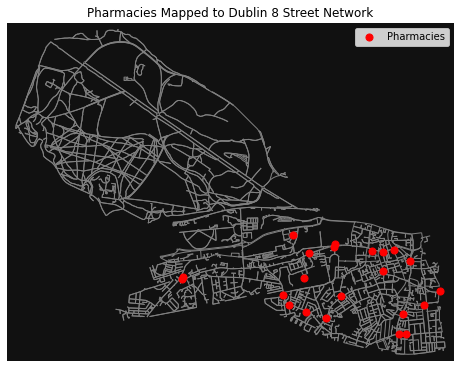

In [6]:
# Step 5: Visualize Pharmacies and the Dublin 8 Street Network
fig, ax = ox.plot_graph(G, show=False, close=False, node_size=0, edge_color="gray")

# Plot pharmacy locations
pharmacies_points.plot(ax=ax, color="red", markersize=50, label="Pharmacies")

plt.legend()
plt.title("Pharmacies Mapped to Dublin 8 Street Network")
plt.show()


# Generating Customer Locations

In [9]:
def random_point_in_polygon(polygon):
    """Generate a random point within a polygon."""
    minx, miny, maxx, maxy = polygon.bounds
    while True:
        random_point = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if polygon.contains(random_point):
            return random_point

def generate_valid_customer_nodes(G, polygon, num_customers=50):
    """Generate customer nodes only on the largest connected component of the graph."""
    # Extract the largest connected component
    G_lcc = max(nx.strongly_connected_components(G), key=len)
    G = G.subgraph(G_lcc).copy()

    # Generate valid nodes
    valid_nodes = list(G.nodes())
    customer_nodes = []

    while len(customer_nodes) < num_customers:
        random_point = random_point_in_polygon(polygon)
        try:
            nearest_node = ox.distance.nearest_nodes(G, random_point.x, random_point.y)
            if nearest_node in valid_nodes:
                customer_nodes.append(nearest_node)
        except Exception as e:
            print(f"Skipping invalid point: {e}")

    return customer_nodes

# Generate 50 valid customer nodes
customer_nodes = generate_valid_customer_nodes(G, dublin8_polygon, num_customers=50)
print(f"Generated {len(customer_nodes)} valid customer locations.")


Generated 50 valid customer locations.


- Generates random customer locations within the Dublin 8 boundary polygon.
- Maps these locations to valid graph nodes:
- Ensures nodes are within the largest connected component of the graph.
- Filters invalid or unreachable nodes.

## Visualizing Pharmacies and Customers

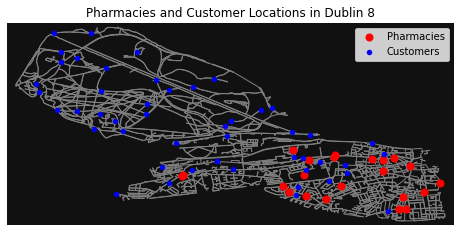

In [10]:
# Plot street network
fig, ax = ox.plot_graph(G, show=False, close=False, node_size=0, edge_color="gray")

# Plot pharmacies
pharmacies_points.plot(ax=ax, color="red", markersize=50, label="Pharmacies")

# Plot customer locations
customer_points = gpd.GeoDataFrame(geometry=[Point(G.nodes[node]['x'], G.nodes[node]['y']) for node in customer_nodes])
customer_points.plot(ax=ax, color="blue", markersize=20, label="Customers")

# Finalize visualization
plt.legend()
plt.title("Pharmacies and Customer Locations in Dublin 8")
plt.show()


# Assigning Customers to the Nearest Pharmacy Based on Travel Time

In [11]:
# Step 1: Assign each customer to the nearest pharmacy based on travel time
from heapq import heappop, heappush

def assign_nearest_pharmacy(customers, pharmacies, G):
    """
    Assigns the nearest pharmacy node to each customer node based on travel time.
    """
    customer_pharmacy_pairs = []
    for cust_node in customers:
        min_time = float("inf")
        nearest_pharmacy = None
        for pharm_node in pharmacies:
            try:
                travel_time = nx.shortest_path_length(G, source=pharm_node, target=cust_node, weight="travel_time")
                if travel_time < min_time:
                    min_time = travel_time
                    nearest_pharmacy = pharm_node
            except nx.NetworkXNoPath:
                continue  # Skip if no path exists
        if nearest_pharmacy is not None:
            customer_pharmacy_pairs.append((nearest_pharmacy, cust_node))
    return customer_pharmacy_pairs

# Map customers to their nearest pharmacies
customer_pharmacy_pairs = assign_nearest_pharmacy(customer_nodes, pharmacy_nodes, G)
print("Assigned Customer-Pharmacy Pairs:")
print(customer_pharmacy_pairs)


Assigned Customer-Pharmacy Pairs:
[(7154459197, 15855903), (746555666, 1426048903), (7154459197, 443627860), (7154459197, 11691289127), (11289753469, 2372759920), (7154459197, 455588913), (7154459197, 5606170694), (7154459197, 518606038), (3124957094, 366986329), (7154459197, 1348557073), (7154459197, 9216677981), (2373707677, 359102304), (7154459197, 2942887454), (7154459197, 886374342), (7154459197, 529135298), (2372740896, 366987125), (7154459197, 1347348819), (7154459197, 4234627445), (7154459197, 1932053013), (7154459197, 391339810), (7154459197, 518606038), (7154459197, 7554705917), (7154459197, 11395530372), (2374666531, 2136737707), (7154459197, 886347743), (2406953463, 3731542219), (8672320804, 6389471494), (7154459197, 11243561403), (7154459197, 5752399800), (7154459197, 886374404), (224035897, 298720605), (2891634691, 1430190438), (7154459197, 6188736396), (7154459197, 2893532813), (7154459197, 10315338521), (7154459197, 570325372), (7154459197, 462642670), (7154459197, 6196

- This function assigns each customer to the nearest pharmacy based on shortest travel time.
- It uses networkx.shortest_path_length with travel_time as the weight.
- If no path exists between a customer and a pharmacy, the function skips that customer.

# Grouping Customer Orders by Pharmacy and Proximity

In [12]:
def group_orders_by_pharmacy(customer_pharmacy_pairs, G, max_distance=500):
    """
    Groups customers assigned to the same pharmacy into smaller delivery batches
    based on a distance threshold (max_distance).
    """
    grouped_orders = {}
    
    for pharm_node, cust_node in customer_pharmacy_pairs:
        if pharm_node not in grouped_orders:
            grouped_orders[pharm_node] = []
        grouped_orders[pharm_node].append(cust_node)
    
    # Split groups based on distance threshold
    final_groups = []
    for pharm_node, customers in grouped_orders.items():
        while customers:
            group = [customers.pop(0)]
            to_remove = []
            for idx, other_cust in enumerate(customers):
                try:
                    distance = nx.shortest_path_length(G, source=group[0], target=other_cust, weight="travel_time")
                    if distance <= max_distance:
                        group.append(other_cust)
                        to_remove.append(idx)
                except nx.NetworkXNoPath:
                    continue
            # Remove grouped customers
            for idx in sorted(to_remove, reverse=True):
                customers.pop(idx)
            final_groups.append((pharm_node, group))
    return final_groups

# Group orders by pharmacy and proximity
max_group_distance = 500  # in meters
grouped_orders = group_orders_by_pharmacy(customer_pharmacy_pairs, G, max_distance=max_group_distance)

# Print grouped orders for delivery
print("Grouped Orders for Delivery:")
for pharmacy, group in grouped_orders:
    print(f"Pharmacy Node {pharmacy} -> Customers: {group}")


Grouped Orders for Delivery:
Pharmacy Node 7154459197 -> Customers: [15855903, 443627860, 5606170694, 518606038, 529135298, 391339810, 518606038, 11395530372, 11243561403, 6188736396, 2893532813, 462642670, 6196929783, 11691289070, 11945284122, 11610864929, 2392040848, 4429487046]
Pharmacy Node 7154459197 -> Customers: [11691289127, 455588913, 1348557073, 9216677981, 2942887454, 886374342, 1347348819, 4234627445, 1932053013, 7554705917, 886347743, 5752399800, 886374404, 10315338521, 570325372, 11079177956, 944342157, 7554707644]
Pharmacy Node 746555666 -> Customers: [1426048903, 912115758]
Pharmacy Node 11289753469 -> Customers: [2372759920]
Pharmacy Node 3124957094 -> Customers: [366986329]
Pharmacy Node 2373707677 -> Customers: [359102304]
Pharmacy Node 2372740896 -> Customers: [366987125]
Pharmacy Node 2374666531 -> Customers: [2136737707, 2136737707]
Pharmacy Node 2406953463 -> Customers: [3731542219, 12640083]
Pharmacy Node 8672320804 -> Customers: [6389471494]
Pharmacy Node 22403

- Groups customer orders that are assigned to the same pharmacy.
- Splits orders into smaller batches based on a distance threshold (e.g., 500 meters).
- This ensures efficient delivery routes by combining nearby orders into a single trip.

In [68]:
# Updated Rider class
class Courier:
    def __init__(self, env, pharmacy_node):
        self.env = env
        self.pharmacy_node = pharmacy_node
        self.available = True  # Indicates if the rider is free

# Optimizing Delivery Routes Using TSP Approximation

In [81]:
# TSP Route Function with Reachability Check
def approximate_tsp_route(G, start_node, customer_nodes, rider_speed):
    """
    Greedy nearest-neighbor TSP approximation for routing multiple deliveries.
    Travel times are calculated dynamically based on rider's speed in km/h.
    """
    route = [start_node]
    current_node = start_node
    remaining_nodes = set(customer_nodes)
    total_time = 0

    while remaining_nodes:
        try:
            # Find the nearest reachable node
            nearest_node = min(
                remaining_nodes,
                key=lambda x: nx.shortest_path_length(G, source=current_node, target=x, weight="length")
            )
            travel_distance = nx.shortest_path_length(G, source=current_node, target=nearest_node, weight="length") / 1000  # meters to km
            travel_time = travel_distance / rider_speed * 60  # km/h to minutes
            total_time += travel_time
            current_node = nearest_node
            route.append(nearest_node)
            remaining_nodes.remove(nearest_node)
        except (nx.NetworkXNoPath, KeyError):
            print(f"Warning: Cannot reach node {nearest_node}. Skipping.")
            remaining_nodes.remove(nearest_node)

    # Return to the start node
    try:
        travel_distance = nx.shortest_path_length(G, source=current_node, target=start_node, weight="length") / 1000
        total_time += travel_distance / rider_speed * 60
        route.append(start_node)
    except (nx.NetworkXNoPath, KeyError):
        print(f"Warning: Cannot return to start node {start_node}.")

    return total_time, route

- Implements a Greedy Nearest-Neighbor TSP (Traveling Salesperson Problem) algorithm.
- Calculates the shortest delivery route starting from a pharmacy and visiting all assigned customers.
- Considers the rider's speed to compute travel time dynamically.
- Ensures that delivery times are minimized for each batch of orders.

# Simulating Multi-Order Deliveries with Riders

In [82]:
def handle_multi_order(env, rider, rider_speed, pharmacy_node, customer_nodes, G, results, routes, riders):
    """
    Handles multiple orders, calculates delivery and transit times accurately.
    """
    print(f"{rider['name']} assigned to Pharmacy Node {pharmacy_node} for customers: {customer_nodes}")
    prep_time = random.uniform(1, 2)  # Time spent preparing orders at the pharmacy
    yield env.timeout(prep_time)  # Simulate preparation time
    order_ready_time = env.now  # Time when orders are ready for delivery

    total_time, route = approximate_tsp_route(G, pharmacy_node, customer_nodes, rider_speed)
    routes.append(route)

    prev_node = route[0]  # Start at the pharmacy
    current_time = env.now

    for i in range(1, len(route) - 1):  # Visit each customer node
        customer_node = route[i]
        travel_distance = nx.shortest_path_length(G, source=prev_node, target=customer_node, weight="length") / 1000
        travel_time = travel_distance / rider_speed * 60  # Rider speed in km/h -> time in minutes
        yield env.timeout(travel_time)  # Simulate travel time

        delivery_time = env.now  # Delivery completion time
        transit_time = delivery_time - order_ready_time
        results.append((rider['name'], customer_node, transit_time, delivery_time))
        print(f"{rider['name']} delivered to customer {customer_node} at {delivery_time:.2f} minutes "
              f"(Transit Time: {transit_time:.2f} minutes).")

        prev_node = customer_node
        order_ready_time = env.now  # Reset transit start time for the next delivery

    rider['position'] = prev_node  # Update rider's position
    rider['available'] = True  # Mark rider as available again


In [83]:
def assign_orders_multi(env, orders, riders, G, results, routes, max_orders_per_trip=3):
    """
    Assigns multiple nearby orders to the nearest available riders dynamically.
    """
    while orders:
        for rider in riders:
            if rider['available'] and orders:
                # Assign orders to the nearest available rider
                pharmacy_node, customer_node = orders.pop(0)
                nearby_orders = [customer_node]

                # Add nearby orders
                to_remove = []
                for idx, (p_node, c_node) in enumerate(orders):
                    if p_node == pharmacy_node and len(nearby_orders) < max_orders_per_trip:
                        nearby_orders.append(c_node)
                        to_remove.append(idx)
                for idx in sorted(to_remove, reverse=True):
                    orders.pop(idx)

                # Assign orders
                rider['available'] = False
                print(f"{rider['name']} assigned to Pharmacy Node {pharmacy_node} for customers: {nearby_orders}")
                env.process(
                    handle_multi_order(
                        env, rider, random.uniform(25, 30), pharmacy_node, nearby_orders, G, results, routes, riders
                    )
                )
        yield env.timeout(0.1)  # Allow other events to proceed


In [97]:
import plotly.graph_objects as go

def visualize_deliveries_plotly_fixed(G, pharmacy_nodes, results, routes, time_threshold=10):
    """
    Visualizes the delivery simulation with Plotly:
    - Pharmacies: Blue markers
    - On-Time Deliveries: Green markers
    - Late Deliveries: Red markers
    - Routes: Orange lines
    """
    # Create figure
    fig = go.Figure()

    # Plot graph edges
    for u, v, data in G.edges(data=True):
        x0, y0 = G.nodes[u]['x'], G.nodes[u]['y']
        x1, y1 = G.nodes[v]['x'], G.nodes[v]['y']
        fig.add_trace(go.Scatter(
            x=[x0, x1], y=[y0, y1],
            mode="lines",
            line=dict(color="lightgray", width=1),
            hoverinfo="none",
            showlegend=False
        ))

    # Pharmacies (add once)
    pharmacy_x = [G.nodes[node]['x'] for node in pharmacy_nodes]
    pharmacy_y = [G.nodes[node]['y'] for node in pharmacy_nodes]
    fig.add_trace(go.Scatter(
        x=pharmacy_x, y=pharmacy_y,
        mode="markers+text",
        marker=dict(size=10, color="blue"),
        text=["P" for _ in pharmacy_nodes],
        textposition="top center",
        name="Pharmacies",
        showlegend=True
    ))

    # On-Time Deliveries (group into one trace)
    on_time_x, on_time_y, on_time_riders = [], [], []
    late_x, late_y, late_riders = [], [], []

    for rider_name, customer_node, transit_time, delivery_time in results:
        if G.has_node(customer_node):
            x, y = G.nodes[customer_node]['x'], G.nodes[customer_node]['y']
            if transit_time <= time_threshold:
                on_time_x.append(x)
                on_time_y.append(y)
                on_time_riders.append(rider_name)
            else:
                late_x.append(x)
                late_y.append(y)
                late_riders.append(rider_name)

    # Add On-Time Deliveries
    fig.add_trace(go.Scatter(
        x=on_time_x, y=on_time_y,
        mode="markers+text",
        marker=dict(size=8, color="green"),
        text=on_time_riders,
        textposition="bottom center",
        name="On-Time Delivery",
        showlegend=True
    ))

    # Add Late Deliveries
    fig.add_trace(go.Scatter(
        x=late_x, y=late_y,
        mode="markers+text",
        marker=dict(size=8, color="red"),
        text=late_riders,
        textposition="bottom center",
        name="Late Delivery",
        showlegend=True
    ))

    # Routes (add once as "Routes")
    for route in routes:
        for i in range(len(route) - 1):
            u, v = route[i], route[i + 1]
            if G.has_edge(u, v):
                x0, y0 = G.nodes[u]['x'], G.nodes[u]['y']
                x1, y1 = G.nodes[v]['x'], G.nodes[v]['y']
                fig.add_trace(go.Scatter(
                    x=[x0, x1], y=[y0, y1],
                    mode="lines",
                    line=dict(color="orange", width=2),
                    hoverinfo="none",
                    showlegend=False if i > 0 else True,
                    name="Routes" if i == 0 else None
                ))

    # Update layout
    fig.update_layout(
        title="Optimized Medicine Delivery Simulation in Dublin 8",
        xaxis_title="Longitude",
        yaxis_title="Latitude",
        plot_bgcolor="white",
        paper_bgcolor="white",
        showlegend=True,
        width=1200,  # Large plot width
        height=800,  # Large plot height
    )
    fig.show()


In [85]:
def run_multi_order_simulation(env, orders, pharmacies, G, num_riders=5):
    """
    Simulates delivery with multiple riders picking up orders dynamically.
    """
    # Create a list of rider dictionaries with speed and availability
    riders = [
        {"id": i + 1, "name": f"Rider {i + 1}", "position": random.choice(pharmacies), "available": True}
        for i in range(num_riders)
    ]

    results, routes = [], []  # To store simulation results and routes
    env.process(assign_orders_multi(env, orders, riders, G, results, routes))
    env.run()  # Run the simulation
    return results, routes


Simulates the delivery process with multiple riders picking up and delivering orders:
- Riders are assigned batches of orders dynamically.
- Each rider follows the optimized route using the TSP approximation.

Calculates:
- Transit Time: Time spent delivering orders after pickup.
- Delivery Completion Time: Total time from order readiness to delivery.

Results include:
- Individual delivery times for each customer.
- Overall performance metrics like average delivery time and on-time delivery rate.

# Results and Performance Metrics

In [86]:
# Generate orders dynamically
orders = assign_nearest_pharmacy(customer_nodes, pharmacy_nodes, G)

# Run the multi-order simulation
env = simpy.Environment()
results, routes = run_multi_order_simulation(env, orders, pharmacy_nodes, G, num_riders=5)

# Results
if results:
    transit_times = [transit_time for _, _, transit_time, _ in results]
    delivery_times = [delivery_time for _, _, _, delivery_time in results]

    avg_transit_time = sum(transit_times) / len(transit_times)
    avg_delivery_time = sum(delivery_times) / len(delivery_times)
    on_time_deliveries = sum(1 for transit_time in transit_times if transit_time <= 10)
    on_time_percentage = (on_time_deliveries / len(transit_times)) * 100

    print(f"\nSimulation Results with Rider Speeds and Accurate Times:")
    print(f"Average Transit Time: {avg_transit_time:.2f} minutes")
    print(f"Average Delivery Time: {avg_delivery_time:.2f} minutes")
    print(f"On-Time Delivery Rate (≤10 minutes): {on_time_percentage:.2f}%")
else:
    print("No deliveries were completed.")

Rider 1 assigned to Pharmacy Node 7154459197 for customers: [15855903, 443627860, 11691289127]
Rider 2 assigned to Pharmacy Node 746555666 for customers: [1426048903, 912115758]
Rider 3 assigned to Pharmacy Node 11289753469 for customers: [2372759920]
Rider 4 assigned to Pharmacy Node 7154459197 for customers: [455588913, 5606170694, 518606038]
Rider 5 assigned to Pharmacy Node 3124957094 for customers: [366986329]
Rider 1 assigned to Pharmacy Node 7154459197 for customers: [15855903, 443627860, 11691289127]
Rider 2 assigned to Pharmacy Node 746555666 for customers: [1426048903, 912115758]
Rider 3 assigned to Pharmacy Node 11289753469 for customers: [2372759920]
Rider 4 assigned to Pharmacy Node 7154459197 for customers: [455588913, 5606170694, 518606038]
Rider 5 assigned to Pharmacy Node 3124957094 for customers: [366986329]
Rider 5 delivered to customer 366986329 at 1.90 minutes (Transit Time: 0.52 minutes).
Rider 5 assigned to Pharmacy Node 7154459197 for customers: [1348557073, 921

Displays the overall results of the delivery simulation, including:
- Average Transit Time: The average time riders take to deliver orders after pickup.
- Average Delivery Time: The total time from order readiness to delivery.
- On-Time Delivery Rate: Percentage of deliveries completed within the 10-minute target.

# Visualizing Delivery Routes and Results

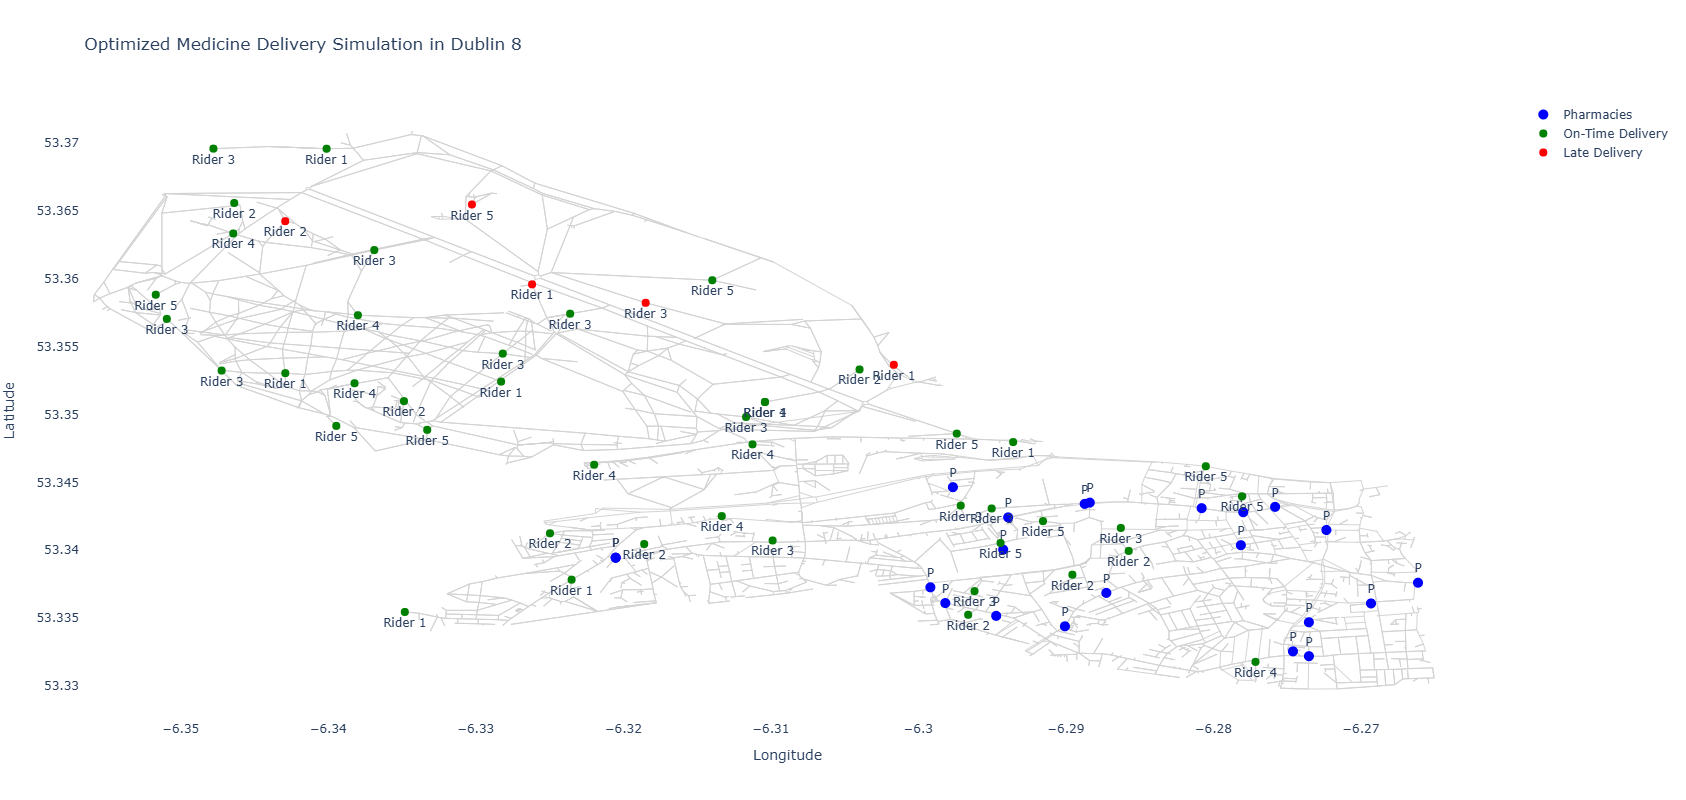

In [98]:
visualize_deliveries_plotly_fixed(G, pharmacy_nodes, results, routes, time_threshold=10)